In [2]:
import NN_Module as nnm
import torch
import polynomial as poly
import numpy as np
import numpy.ma as ma
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
from pandas import read_csv
import argparse
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def loadData(data, key):
    inputs = np.zeros((data['deltaNLL'].shape[0], 16))
    inputs[:,names[key]] = data[key]
    if len(list(data)) > 3:
        for key2 in names.keys():
            inputs[:,names[key2]] = data[key2]
    outputs = data['deltaNLL']
    outputs -= outputs.min()
    outputs *= 2
    dic = {key: inputs, 'deltaNLL': outputs}
    return dic

In [4]:
def modelCalculate(model, dic, key, stats, output_stats,polynomial=False):
    if (polynomial):
        inputs_all = np.zeros((dic['deltaNLL'].shape[0], 16))
        inputs = dic[key]
        inputs_all[:,0:16] = inputs
    else:
        inputs_all = np.zeros((dic['deltaNLL'].shape[0], 152))
        inputs = dic[key]
        inputs_all[:,0:16] = inputs
        inputs_all[:,16:32] = inputs_all[:,0:16]**2
        idx= 32
        for i in range(16):
            for j in range(i):
                inputs_all[:,idx] = inputs_all[:,i] * inputs_all[:,j]
                idx += 1
    std_inputs = nnm.affine_transform(torch.from_numpy(inputs_all).float().cuda(), stats)
    std_outputs = model(std_inputs)
    outputs = nnm.affine_untransform(std_outputs, output_stats).cpu().detach().numpy().flatten()
    outputs -= outputs.min()
    outputs *= 2
    return outputs

In [5]:
def makeGraphs(actual, model, key, currentNum):
    graph = plt.subplots()
    actual_scatter = graph[1].scatter(actual[key][key][:,names[key]], actual[key]['deltaNLL'],marker='.', c='b', s=0.5, linewidths=0.5)
    model_scatter = graph[1].scatter(model[key][key][:,names[key]], model[key]['deltaNLL'], marker='x', c='g', s=1, linewidths=0.2)
    one_line, = graph[1].plot([model[key][key][:,names[key]].min(), model[key][key][:,names[key]].max()], [1,1], 'r--', linewidth=0.5)
    four_line, = graph[1].plot([model[key][key][:,names[key]].min(), model[key][key][:,names[key]].max()], [4,4], 'm:', linewidth=0.5)
    graph[1].legend([actual_scatter, model_scatter, one_line, four_line], ['Target', 'NN Prediction', '$1\sigma\ (2\Delta NLL=1)$', '$2\sigma\ (2\Delta NLL=4)$'], markerscale=6)
    graph[1].set_xlabel(key)
    graph[1].set_ylabel('2$\Delta$NLL')
    if currentNum % 2 != 0:
        graph[1].set_title('Frozen')
    else:
        graph[1].set_title('Profiled')
    graph[0].tight_layout()
    return graph

In [6]:
def makeResidual(data, key):
    graph = plt.subplots()
    graph[1].scatter(data[key][key][:,names[key]], data[key]['deltaNLL'], c='b', s=1)
    graph[1].set_xlabel(key)
    graph[1].set_ylabel('residual (actual - prediction)')
    graph[1].set_title('Frozen')
    graph[0].tight_layout()

In [7]:
def graphModelDifference(residual_data_difference, title):
    graph = plt.subplots()
    average = np.array([])
    names = np.array([])
    distance = np.linspace(0,32,16) 
    for key in residual_data_difference:
        average = np.append(average,np.mean(residual_data_difference[key]))
        names = np.append(names,key)
    graph[1].bar(distance, average, width = 1)
    graph[1].set_xticks(distance)
    graph[1].set_xticklabels(names, rotation=65)
    graph[1].set_title(title)
    graph[1].set_ylabel('Given Model Residual - New Model Residual')
    pp.savefig(graph[0])
    graph[0].tight_layout()

In [17]:
saved_data = torch.load('/scratch365/njamieso/Likelihood/models/6755_13_model+.pt')
best_model_state = saved_data['model']
parameters = saved_data['parameters']
output_stats = saved_data['output_stats']
input_stats = saved_data['input_stats']

saved_data2 = torch.load('/scratch365/njamieso/Likelihood/models/12643_0_model+.pt')
best_model_state2 = saved_data2['model']
parameters2 = saved_data2['parameters']
output_stats2 = saved_data2['output_stats']
input_stats2 = saved_data2['input_stats']

In [18]:
names = {}
names['cQei'] = 0
names['cQl3i'] = 1
names['cQlMi'] = 2
names['cbW'] = 3
names['cpQ3'] = 4
names['cpQM'] = 5
names['cpt'] = 6
names['cptb'] = 7
names['ctG'] = 8
names['ctW'] = 9
names['ctZ'] = 10
names['ctei'] = 11
names['ctlSi'] = 12
names['ctlTi'] = 13
names['ctli'] = 14
names['ctp'] = 15

{'N': 16,
 'train_size': 49378587,
 'test_size': 498773,
 'hidden_nodes': 750,
 'hidden_layers': 2,
 'batch_size': 1024,
 'n_epochs': 152,
 'learning_rate': 0.0001,
 'lr_red_factor': 0.2,
 'lr_red_patience': 20.0,
 'lr_red_threshold': 1e-06,
 'weight_decay': 0.0,
 'accu_out_resolution': 100,
 'out_residual_resolution': 100}

In [19]:
model = nnm.create_model(16, 1, parameters, polynomial=True)
model.load_state_dict(best_model_state)
model.eval()

model2 = nnm.create_model(16, 1, parameters2,polynomial=True)
model2.load_state_dict(best_model_state2)
model2.eval()

Sequential(
  (0): PolynomialLayer(
    (monomial_layer): MonomialLayer()
    (linear): Linear(in_features=152, out_features=700, bias=True)
  )
  (1): ReLU()
  (2): Linear(in_features=700, out_features=700, bias=True)
  (3): ReLU()
  (4): Linear(in_features=700, out_features=700, bias=True)
  (5): ReLU()
  (6): Linear(in_features=700, out_features=1, bias=True)
)

In [20]:
num = 1
actual_data_frozen = {}
actual_data_profiled = {}
model_data_frozen = {}
model_data_profiled = {}
residual_data = {}
residual_data_profiled = {}
frozen_graphs = {}
residual_graphs = {}
profiled_graphs = {}

/srv/ipykernel_22/2617516616.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  graph = plt.subplots()


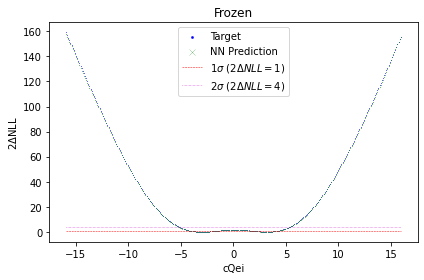

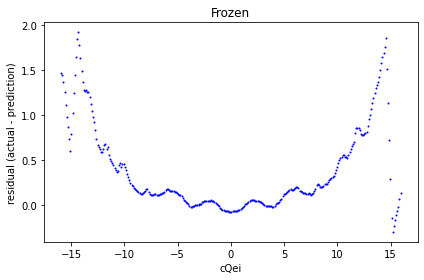

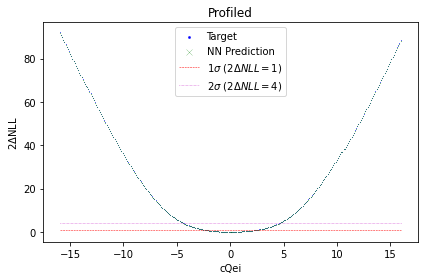

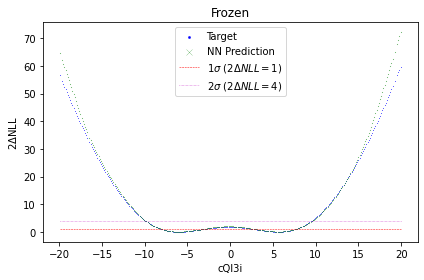

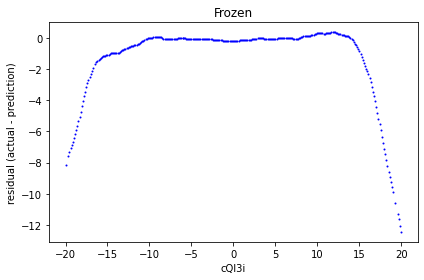

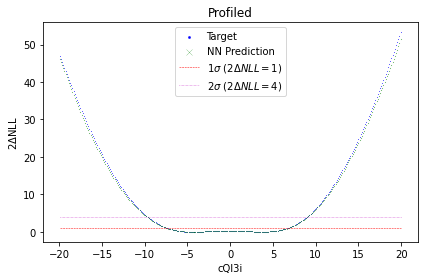

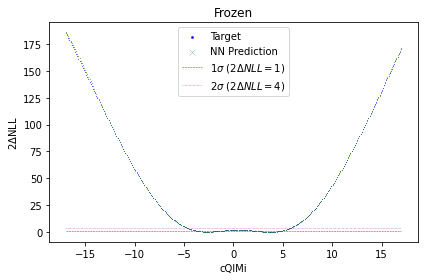

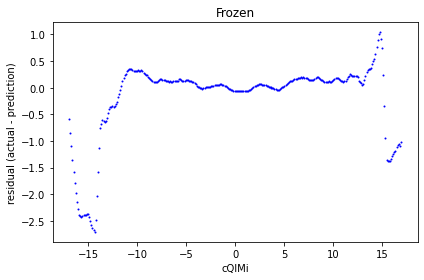

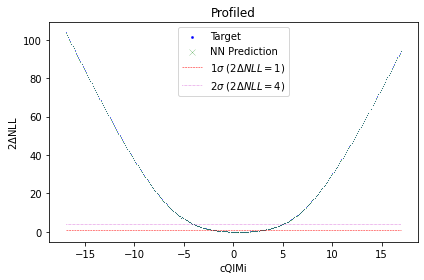

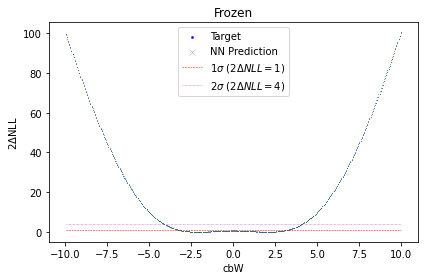

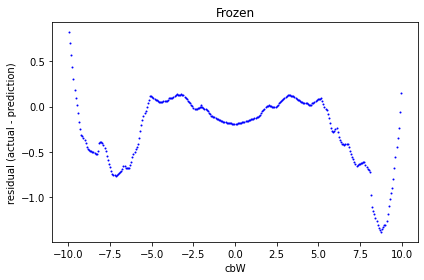

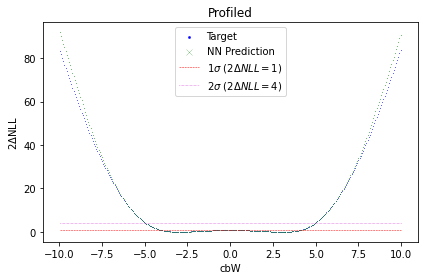

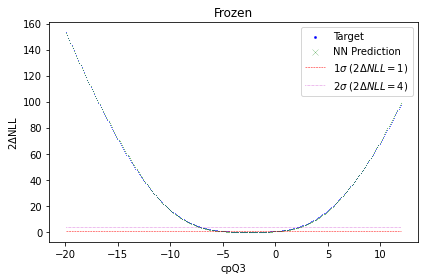

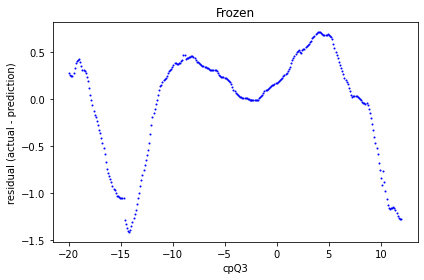

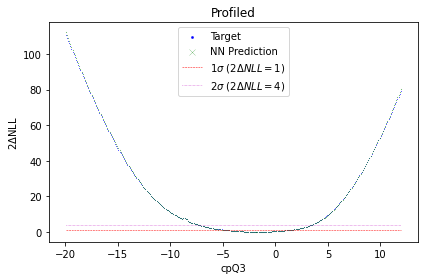

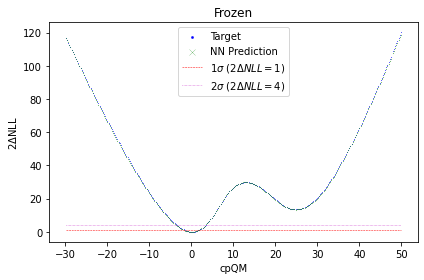

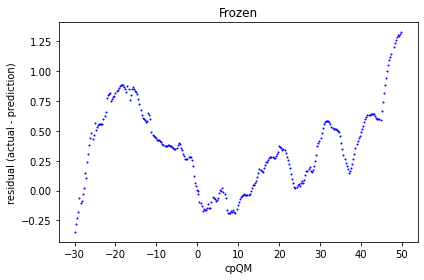

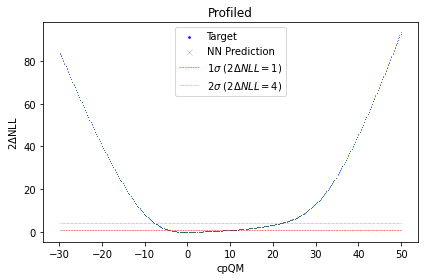

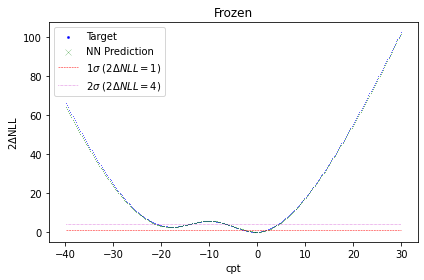

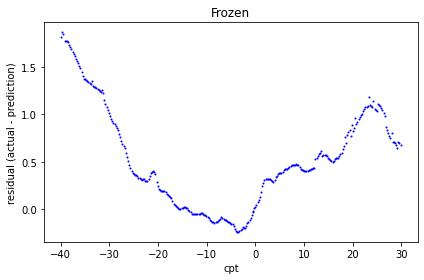

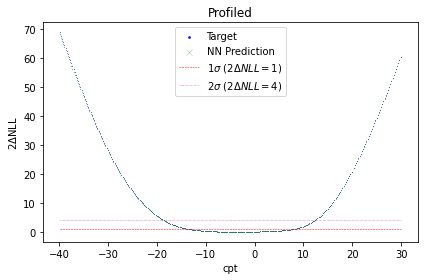

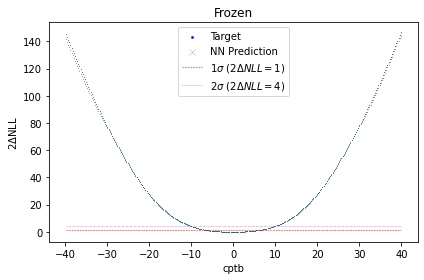

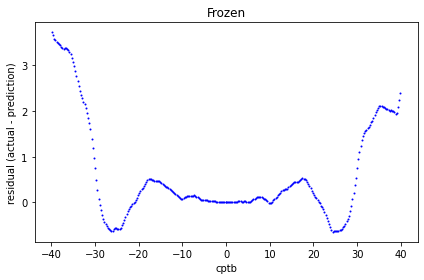

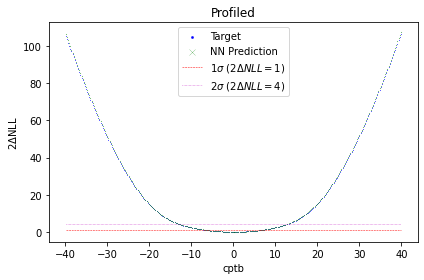

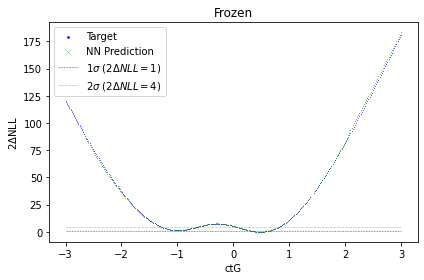

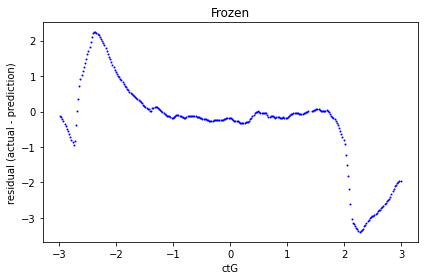

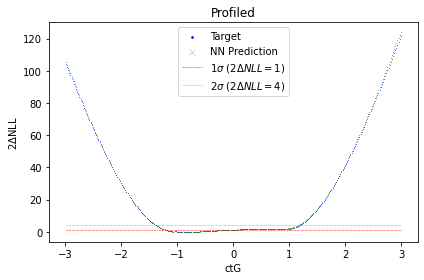

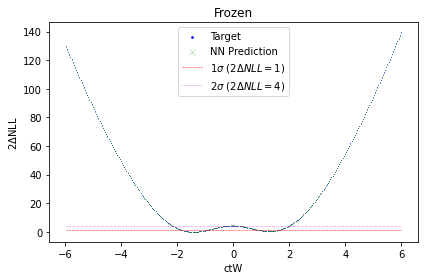

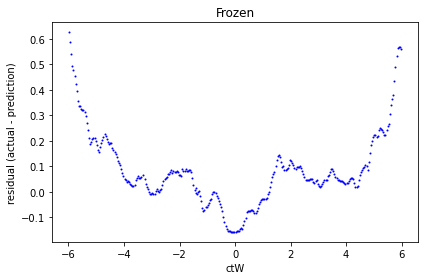

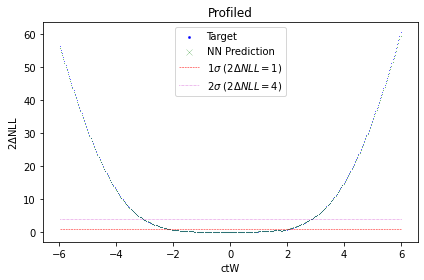

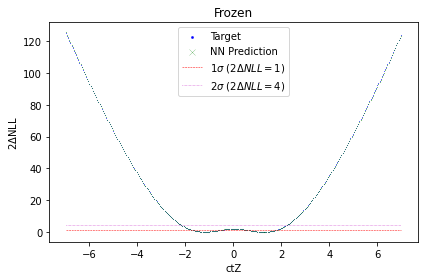

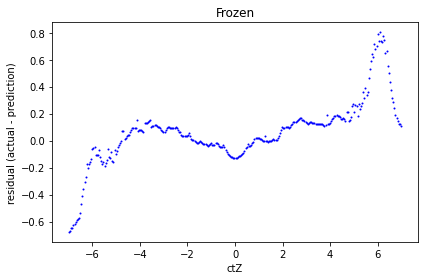

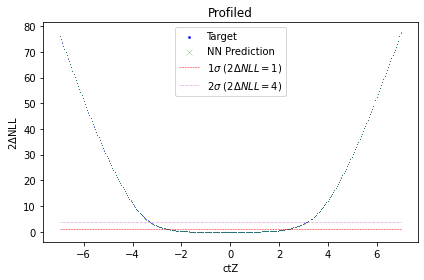

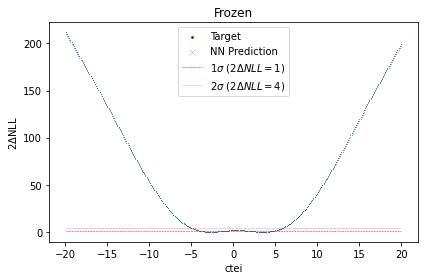

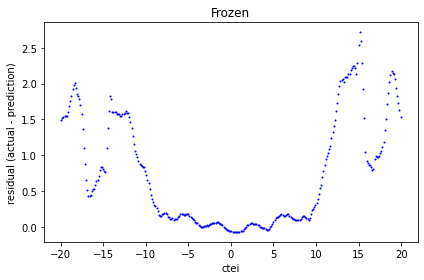

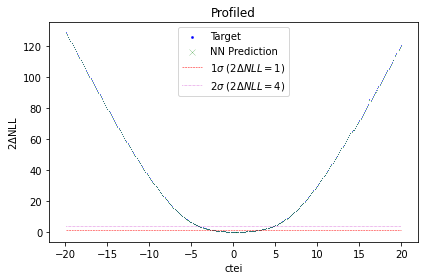

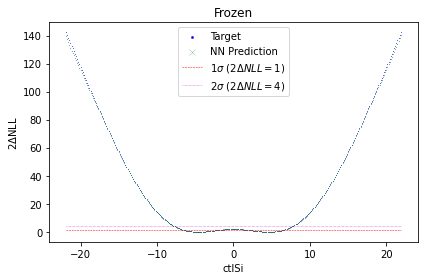

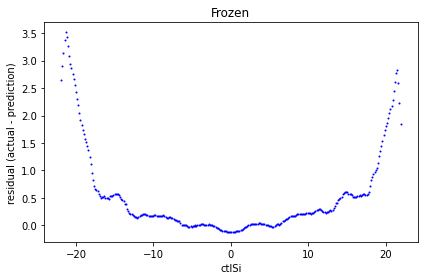

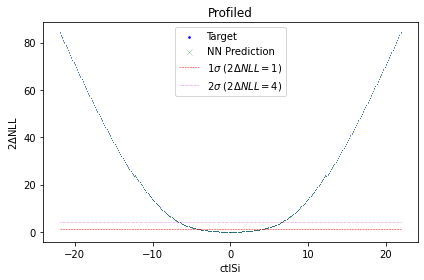

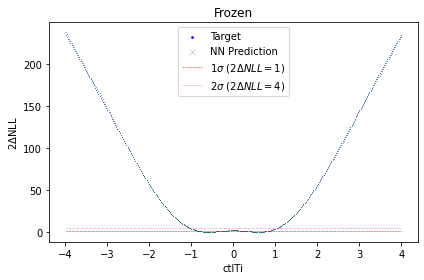

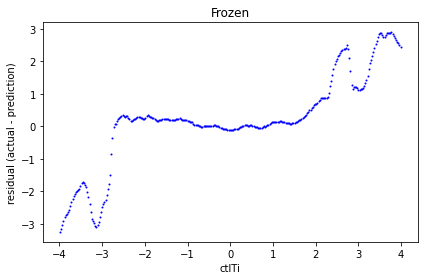

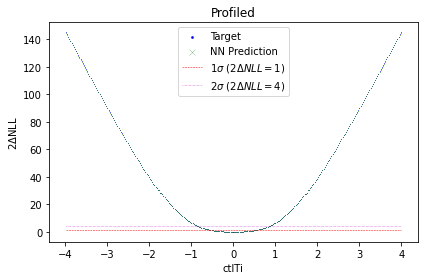

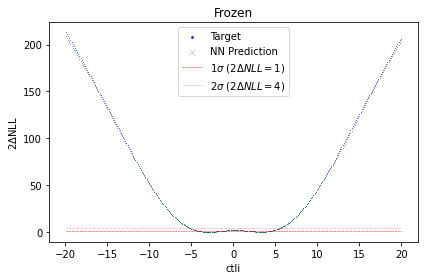

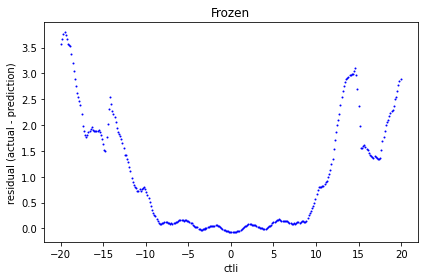

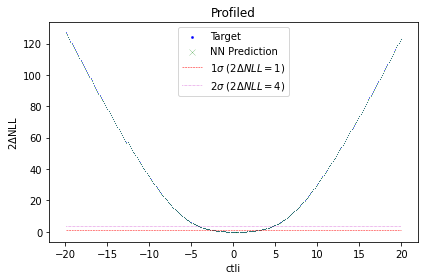

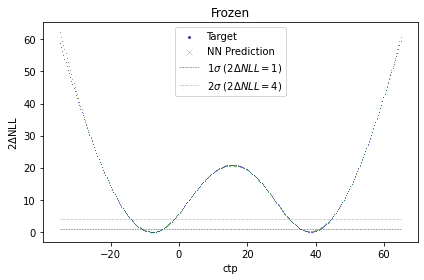

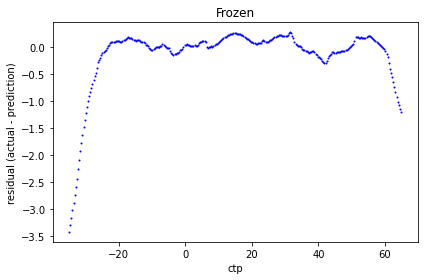

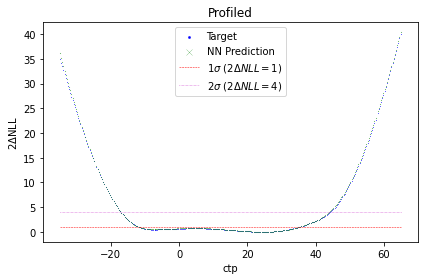

In [21]:
#For first model
for key in names.keys():
    frozen_data = np.load(f'data/likelihood_{key}.npz')
    profiled_data = np.load(f'data/likelihood_profiled_{key}.npz')
    
    actual_data_frozen[key] = loadData(frozen_data,key) 
    actual_data_profiled[key] = loadData(profiled_data,key)
                                      
    model_data_frozen[key] = {key: actual_data_frozen[key][key], 'deltaNLL': modelCalculate(model, actual_data_frozen[key], key, input_stats, output_stats,polynomial=True)}
    model_data_profiled[key] = {key: actual_data_profiled[key][key], 'deltaNLL': modelCalculate(model, actual_data_profiled[key], key, input_stats,output_stats,polynomial=True)}
    residual_data[key] = {key: actual_data_frozen[key][key], 'deltaNLL': actual_data_frozen[key]['deltaNLL']-model_data_frozen[key]['deltaNLL']}
    residual_data_profiled[key] = {key: actual_data_profiled[key][key], 'deltaNLL': actual_data_profiled[key]['deltaNLL']-model_data_profiled[key]['deltaNLL']}
    
    frozen_graphs[key] = makeGraphs(actual_data_frozen, model_data_frozen, key, num)
    num += 1
    residual_graphs[key] = makeResidual(residual_data, key)
    profiled_graphs[key] = makeGraphs(actual_data_profiled, model_data_profiled, key, num)
    num += 1

In [22]:
num = 1
actual_data_frozen2 = {}
actual_data_profiled2 = {}
model_data_frozen2 = {}
model_data_profiled2 = {}
residual_data2 = {}
residual_data_profiled2 = {}
frozen_graphs2 = {}
residual_graphs2 = {}
profiled_graphs2 = {}
model_difference = {}
model_difference_zoomed = {}
model_difference_profiled = {}
model_difference_frozen_zoomed = {}
model_difference_profiled_zoomed = {}
model_difference_std = {}
model_difference_std_profiled = {}
model_std = {}
model_std_profiled = {}

/srv/ipykernel_22/2617516616.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  graph = plt.subplots()


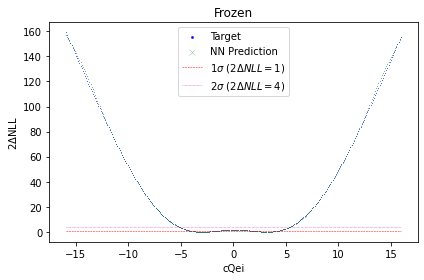

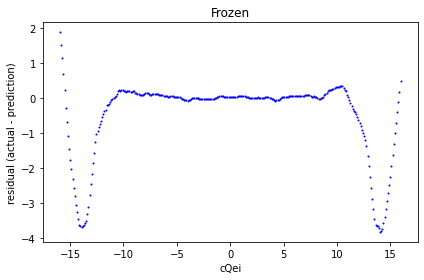

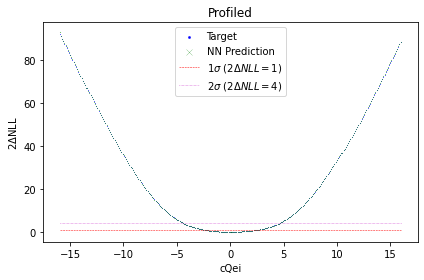

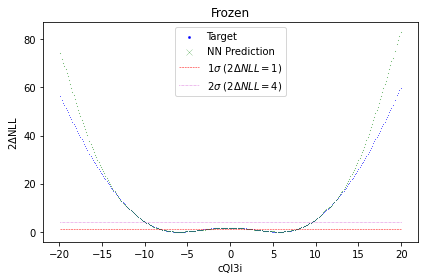

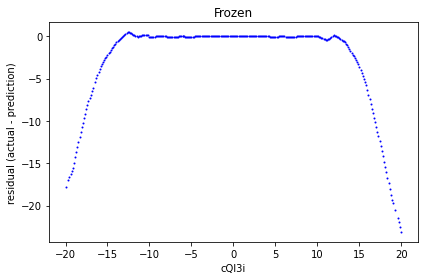

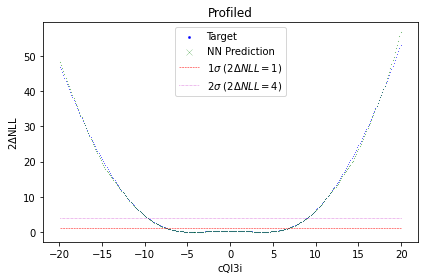

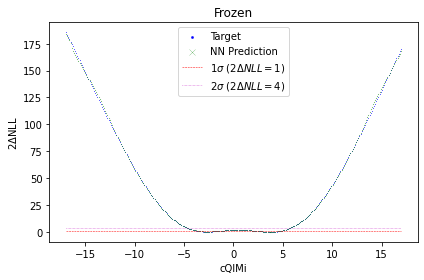

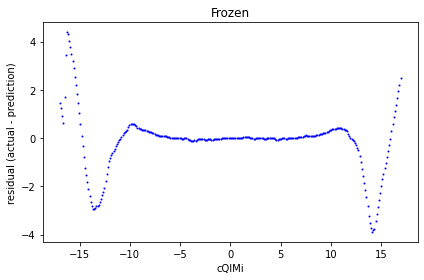

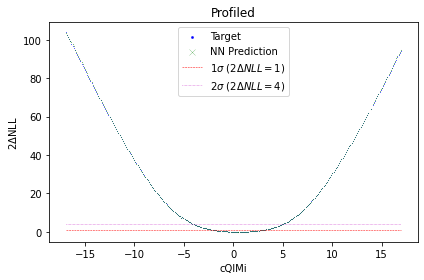

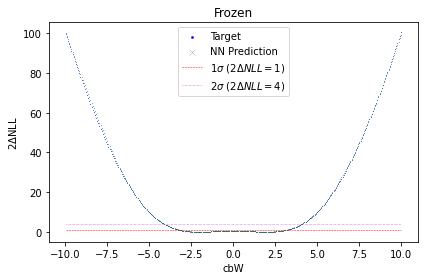

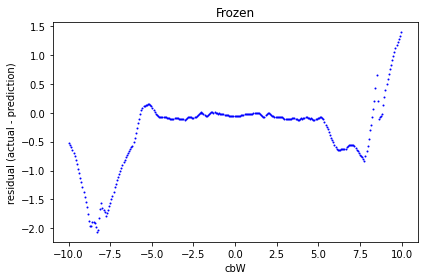

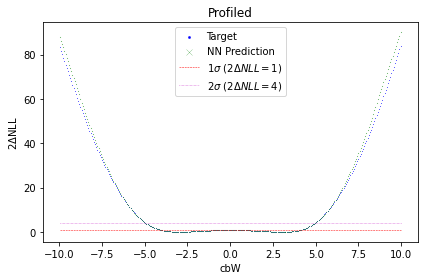

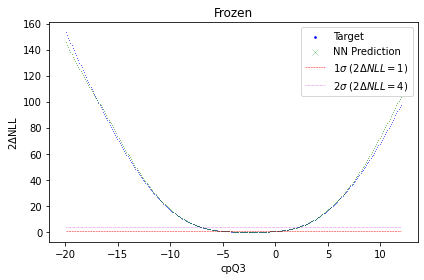

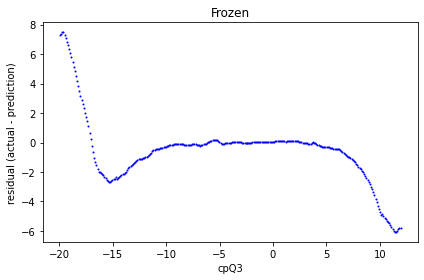

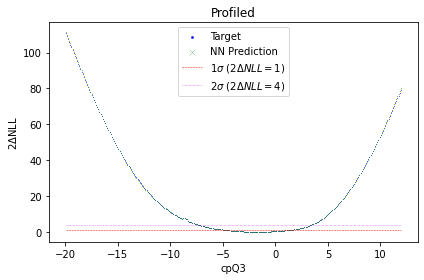

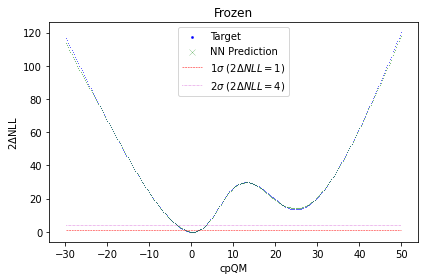

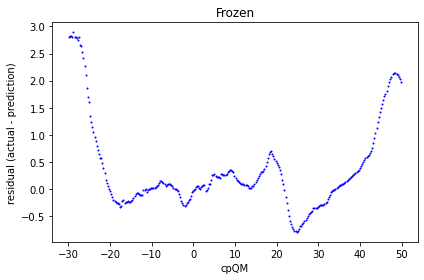

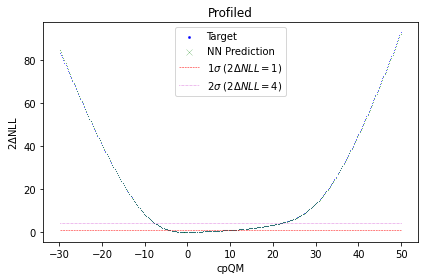

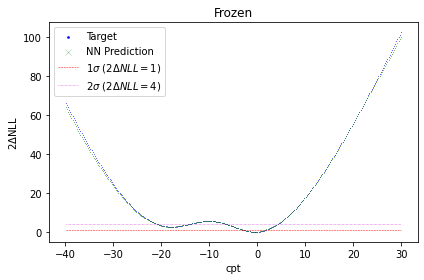

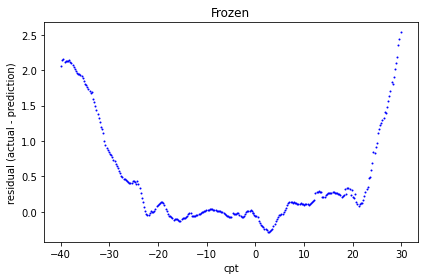

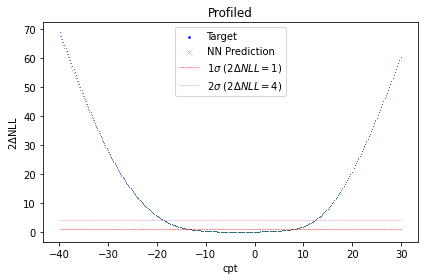

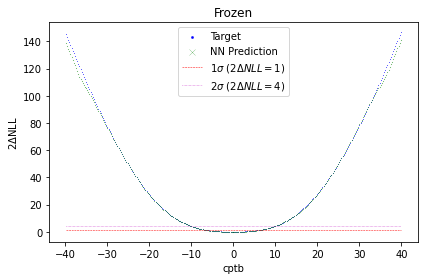

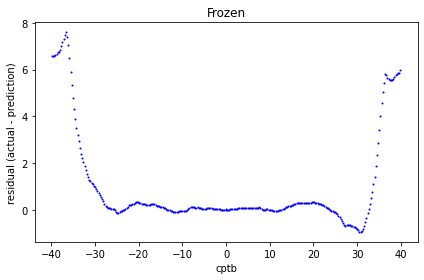

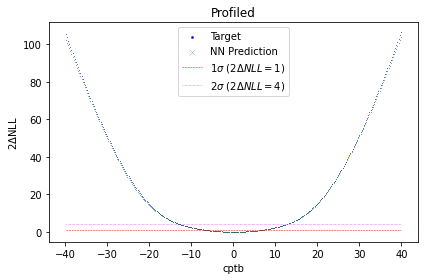

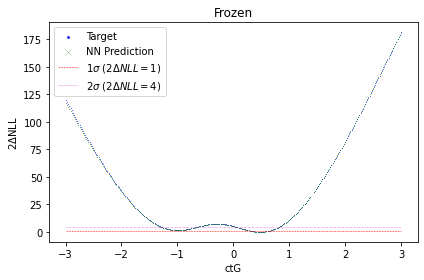

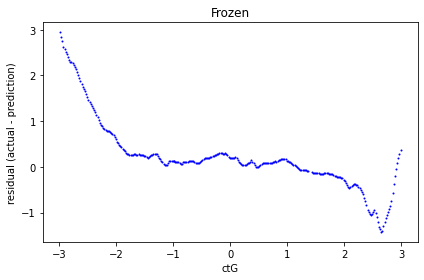

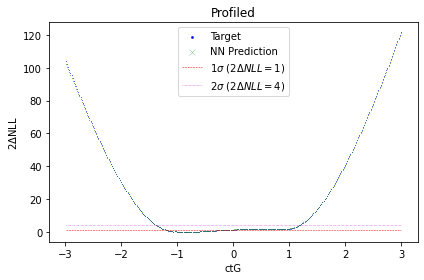

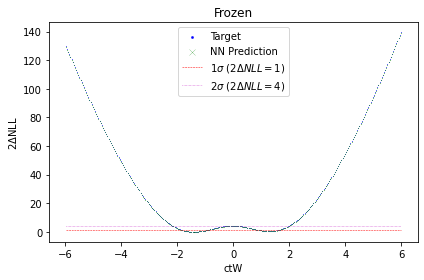

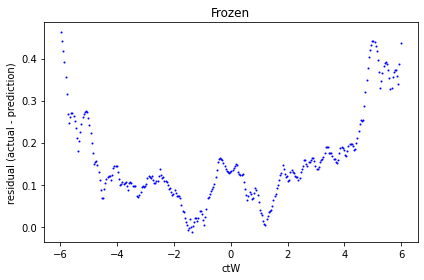

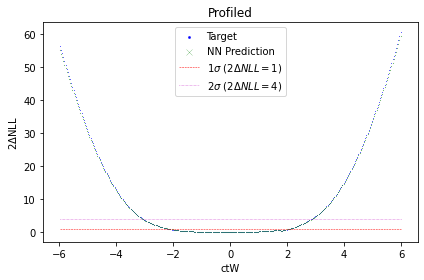

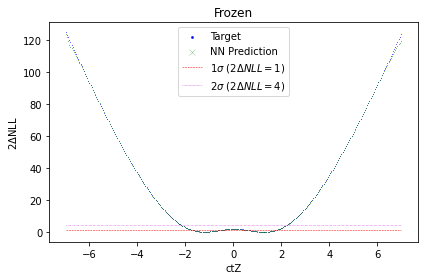

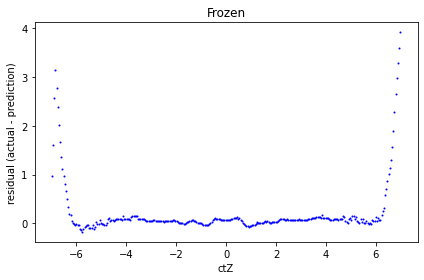

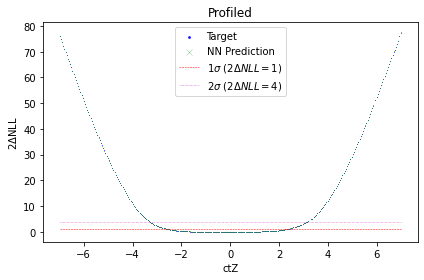

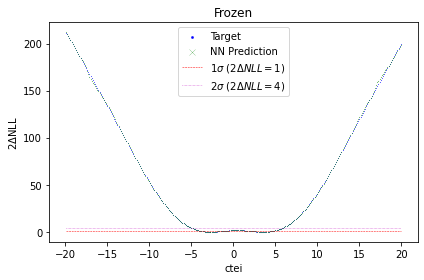

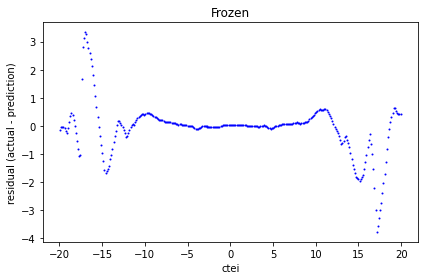

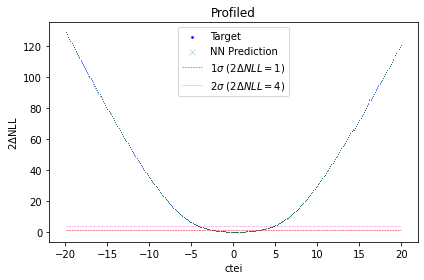

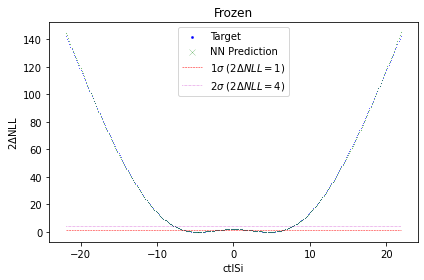

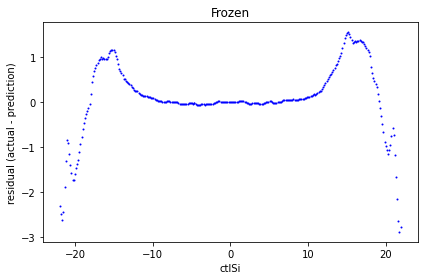

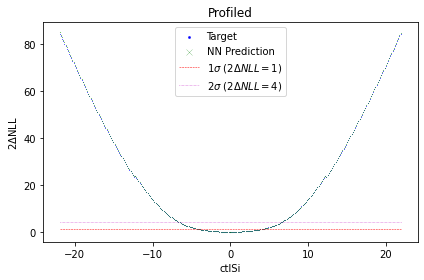

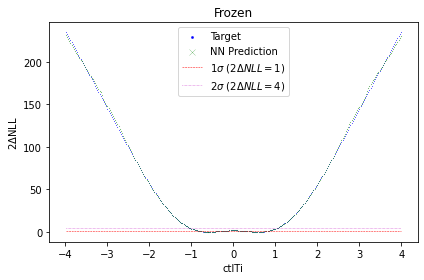

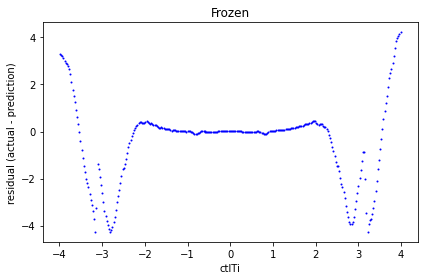

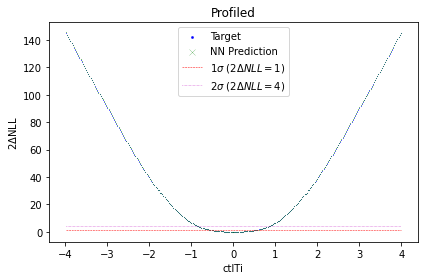

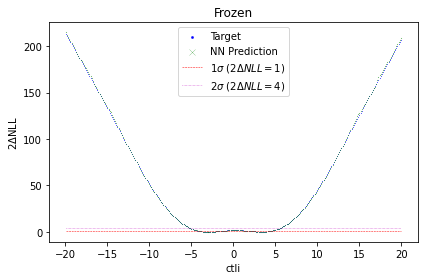

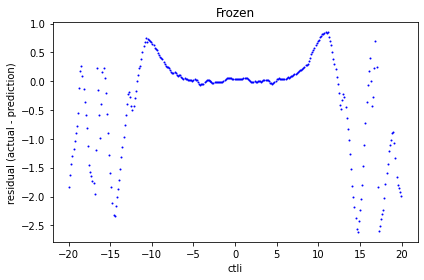

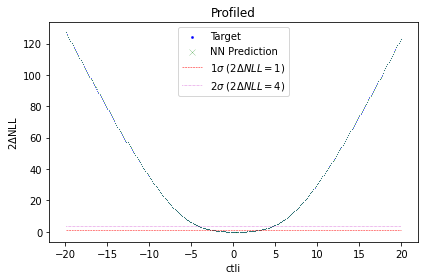

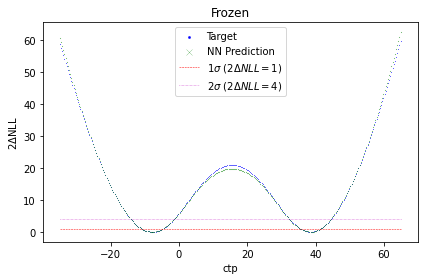

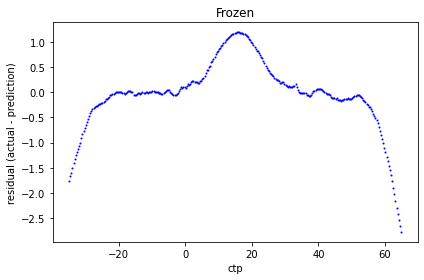

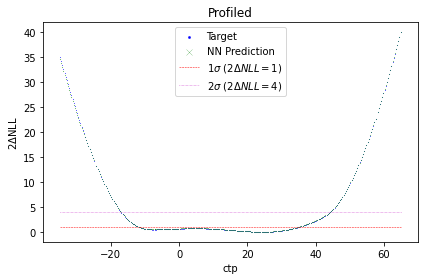

In [23]:
for key in names.keys():
    frozen_data2 = np.load(f'data/likelihood_{key}.npz')
    profiled_data2 = np.load(f'data/likelihood_profiled_{key}.npz')
    
    actual_data_frozen2[key] = loadData(frozen_data2,key) 
    actual_data_profiled2[key] = loadData(profiled_data2,key)
                                      
    model_data_frozen2[key] = {key: actual_data_frozen2[key][key], 'deltaNLL': modelCalculate(model2, actual_data_frozen2[key], key, input_stats2, output_stats2, polynomial = True)}
    model_data_profiled2[key] = {key: actual_data_profiled2[key][key], 'deltaNLL': modelCalculate(model2, actual_data_profiled2[key], key, input_stats2, output_stats2, polynomial = True)}
    residual_data2[key] = {key: actual_data_frozen2[key][key], 'deltaNLL': actual_data_frozen2[key]['deltaNLL']-model_data_frozen2[key]['deltaNLL']}
    residual_data_profiled2[key] = {key: actual_data_profiled2[key][key], 'deltaNLL' : actual_data_profiled2[key]['deltaNLL']-model_data_profiled2[key]['deltaNLL']}

    frozen_graphs2[key] = makeGraphs(actual_data_frozen2, model_data_frozen2, key, num)
    num += 1
    residual_graphs2[key] = makeResidual(residual_data2, key)
    profiled_graphs2[key] = makeGraphs(actual_data_profiled2, model_data_profiled2, key, num)
    num += 1
    
    model_difference[key] = (np.absolute(residual_data[key]['deltaNLL']) - np.absolute(residual_data2[key]['deltaNLL']))
    model_difference_profiled[key] = (np.absolute(residual_data_profiled[key]['deltaNLL']) - np.absolute(residual_data_profiled2[key]['deltaNLL']))
    model_difference_frozen_zoomed[key] = (np.absolute(residual_data[key]['deltaNLL'][actual_data_frozen[key]['deltaNLL'] <10]) - np.absolute(residual_data2[key]['deltaNLL'][actual_data_frozen2[key]['deltaNLL'] <10]))
    model_difference_profiled_zoomed[key] = (np.absolute(residual_data_profiled[key]['deltaNLL'][actual_data_profiled[key]['deltaNLL'] <10]) - np.absolute(residual_data_profiled2[key]['deltaNLL'][actual_data_profiled2[key]['deltaNLL'] <10]))
    model_difference_std[key] = np.std(model_difference[key])
    model_difference_std_profiled[key] = np.std(model_difference_profiled[key])
    model_std[key] = model_difference[key][np.abs(model_difference[key]) <= 2*model_difference_std[key]]
    model_std_profiled[key] = model_difference_profiled[key][np.abs(model_difference_profiled[key]) <= 2*model_difference_std_profiled[key]]

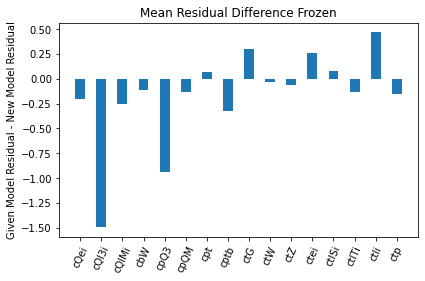

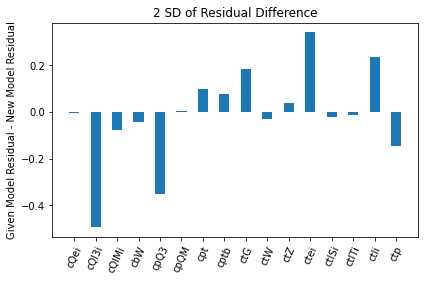

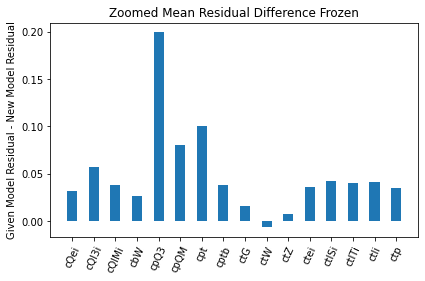

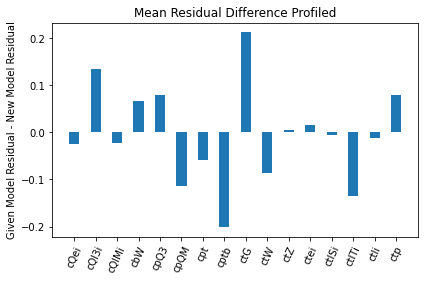

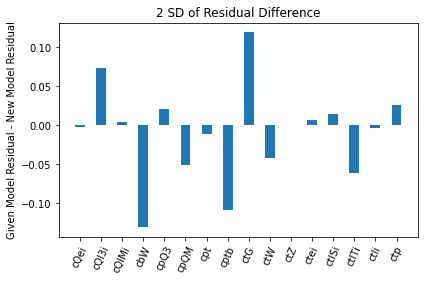

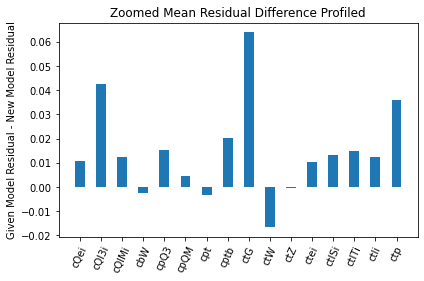

In [25]:
pp = PdfPages('poly v. Poly_validation.pdf')
graphModelDifference(model_difference, 'Mean Residual Difference Frozen')
graphModelDifference(model_std, '2 SD of Residual Difference')
graphModelDifference(model_difference_frozen_zoomed, 'Zoomed Mean Residual Difference Frozen')
graphModelDifference(model_difference_profiled, 'Mean Residual Difference Profiled')
graphModelDifference(model_std_profiled, '2 SD of Residual Difference')
graphModelDifference(model_difference_profiled_zoomed, 'Zoomed Mean Residual Difference Profiled')
pp.close()